<a href="https://colab.research.google.com/github/RenChina/FinPortfolio/blob/master/03_hw_ensembles%D0%91%D0%B0%D0%B1%D0%B5%D0%BD%D0%BA%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашняя работа. Деревья решений.

## Полезная литература

- [Habrahabr: ODS деревья решений](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy)
- [ВМК МГУ семинары по решающим деревьям](99-extra__ml-course-msu-Sem04_trees.pdf)
- [Sklearn Decision Trees](http://scikit-learn.org/stable/modules/tree.html)

## 1. Сравнение моделей деревьев

В этом блоке вы сравните разные конфигурации композиций деревьев:
- DecisionTree
- Bagging
- Bagging с другими настройками подбора признаков для разбиения
- RandomForest

Будем использовать [датасет с винишком](https://archive.ics.uci.edu/ml/datasets/wine+quality) - это задача то ли классификации то ли регресси - нужно предсказывать качество вина. Будем думать что это классификация.

![](https://upload.wikimedia.org/wikipedia/en/thumb/7/7c/Lulz_Security.svg/300px-Lulz_Security.svg.png)

### 1.1 Чтение данных (1 балла)

Данные лежат как обычно в `'./data/winequality-red.csv.gz'`.

- Прочитайте их с помощью pandas
- нарисуйте countplot целевого признака `quality`.
- Что вы думаете по поводу количества представителей каждого класса.
- Разбейте данные на X и y.

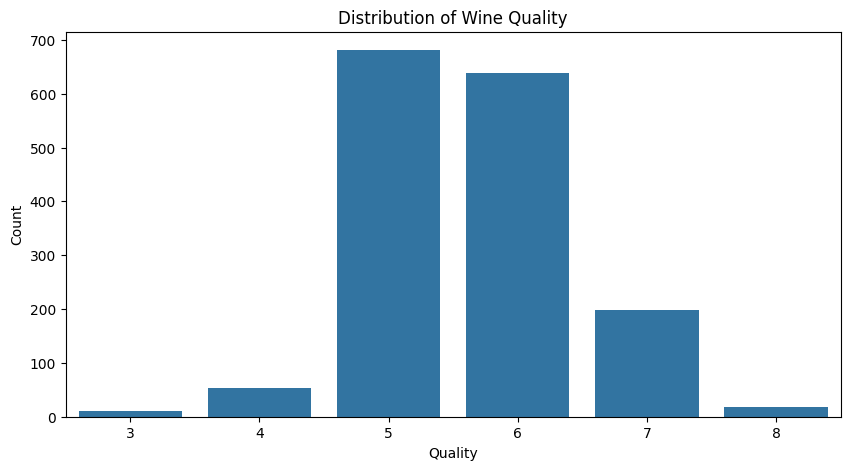

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/content/winequality-red.csv')

plt.figure(figsize=(10, 5))
sns.countplot(x='quality', data=data)
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

X = data.drop('quality', axis=1)
y = data['quality']

Глядя на график распределения качества вина, можно сделать вывод, что классы несбалансированы.  Значительное большинство образцов имеет качество 5 или 6.  Классы с качеством 3, 4, 7, 8 встречаются гораздо реже. Это может создать проблемы для моделей машинного обучения, которые могут быть предвзяты в сторону более часто встречающихся классов.  Для достижения наилучших результатов может потребоваться балансировка классов, например, с помощью  oversampling или undersampling,  или использование метрик, которые учитывают несбалансированность данных, таких как F1-мера



### 1.2 Сравнение моделей (4 балла)

Задача классификации. Все признаки уже числовые. Значит можно пробовать просто все модели и выбрать лучшую. Так и поступим, сделайте кросс валидацию на 5 фолдах, используя `sklearn.model_selection.KFold` как аргумент у `cross_val_score`. Метрика качества будет `accuracy`.

Алгоритмы для тестирования:
- KNeighborsClassifier с 10 соседями
- KNeighborsClassifier с 10 соседями и масштабированием StandartScaler
- RidgeClassifier
- DecisionTreeClassifier
- BaggingClassifier c 100 деревьев
- BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков (см аргументы)
- RandomForestClassifier c 100 деревьев

Выведите среднее значение метрики качества для каждого из классификаторов.

**hint**: каждый следующий алгоритм, будет показывать качество лучше, чем предыдущий. Если у вас не так - то что-то вы делаете неправильно. Везде зафиксируйте random_state=42.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = [
    ('KNN', KNeighborsClassifier(n_neighbors=10)),
    ('KNN Scaled', KNeighborsClassifier(n_neighbors=10)),
    ('Ridge', RidgeClassifier(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(n_estimators=100, random_state=42)),
    ('Bagging Subspace', BaggingClassifier(n_estimators=100, max_features=0.5, random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42))
]

for name, model in models:
  if name == 'KNN Scaled':
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='accuracy')
  else:
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
  print(f'{name}: {scores.mean():.4f}')

KNN: 0.5122
KNN Scaled: 0.5798
Ridge: 0.5835
Decision Tree: 0.6179
Bagging: 0.6980
Bagging Subspace: 0.6948
Random Forest: 0.7017


### 1.3 Расуждения (8 баллов)

Ответьте на вопросы развернуто, можете полистать литературу:

- почему наблюдается значимая разница в качестве у KNeighborsClassifier с масштабированием и без
- почему масштабирование не важно для деревьев решений
- почему бэггинг на половине признаков для каждого дерева дал качество предсказания больше, чем на всех? (а он дал!)
- у какой модели наибольшей отклонение от среднего качества предсказаний? А почему??

1. Почему наблюдается значимая разница в качестве у KNeighborsClassifier с масштабированием и без?
`KNeighborsClassifier` вычисляет расстояние между точками данных для определения ближайших соседей.  Признаки с большими значениями будут оказывать непропорционально большое влияние на вычисление расстояния, подавляя влияние признаков с меньшими значениями.  Масштабирование, такое как `StandardScaler`, нормализует признаки, приводя их к одному масштабу (нулевое среднее и единичное стандартное отклонение). Это устраняет влияние масштаба признаков на вычисление расстояния и позволяет алгоритму KNN более точно учитывать вклад каждого признака в классификацию. Без масштабирования, признаки с большими значениями могут доминировать над другими, что приводит к снижению точности модели


2. Почему масштабирование не важно для деревьев решений?
Деревья решений работают на основе пороговых значений признаков.  Масштабирование признаков не меняет относительный порядок точек данных по отношению к порогу, а значит, не влияет на разделение данных в узлах дерева.  Деревья решений не чувствительны к масштабированию, так как процесс принятия решений основан на сравнении значений с пороговыми значениями, а не на расстояниях между точками


3. Почему бэггинг на половине признаков для каждого дерева дал качество предсказания больше, чем на всех?
Использование подмножества признаков (в данном случае, половины) при построении каждого дерева в бэггинге снижает корреляцию между деревьями.  Если бы каждое дерево обучалось на всех признаках, деревья могли бы быть очень похожими друг на друга, что привело бы к переобучению на обучающих данных.  Использование подмножества признаков способствует диверсификации деревьев, уменьшает переобучение и увеличивает обобщающую способность модели на новых данных.  В результате итоговое предсказание, получаемое усреднением предсказаний нескольких разнообразных деревьев, становится более устойчивым и точным


4. У какой модели наибольшее отклонение от среднего качества предсказаний? А почему?
Для определения модели с наибольшим отклонением нужно вычислить стандартное отклонение метрики качества (accuracy) для каждой модели по результатам кросс-валидации. Модель с наибольшим стандартным отклонением будет иметь наибольшее отклонение от среднего качества предсказаний.  Обычно модели, которые более чувствительны к случайным вариациям в данных или к выбору подмножества данных при кросс-валидации (например, KNN с малым числом соседей),  имеют большее отклонение качества предсказаний.  Высокое отклонение может указывать на нестабильность модели, её зависимость от конкретных выборок данных и меньшую обобщающую способность



## 2 Переобучение и Ко

В последнем задании вы уже заметили, что случайный лес может вести себя немного нестабильно. В этом задании мы возьмем опять датасет MNIST(простите) и будем его решать деревьями. Почему мы взяли его? Потому что в нем фактически много разных признаков (значения пикселей в пространстве), а деревья строятся делая разбиения по признакам. Обычно на эти разбиения не обращают внимание, так как главное что тюнят - это глубина дереьвев, количество деревьев, а кучу других параметров обходят стороной, так как они "неясные". Попробуем прояснить их.

### 2.1 Загрузка датасета (1 балл)

Загрузите датасет с помощью функции `sklearn.datasets.load_digits`. В нем будут 64px картинки в векторной форме.

Нарисуйте первые 10 цифр в одной ячейке, чтобы было красиво.

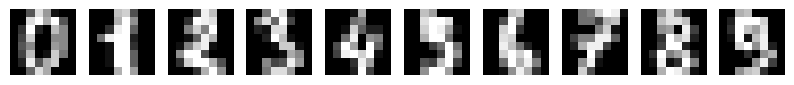

In [18]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()

fig, axes = plt.subplots(1, 10, figsize=(10, 3))
for i in range(10):
    axes[i].imshow(digits.images[i], cmap='gray')
    axes[i].axis('off')
plt.show()

### 2.2 Перебор классификаторов (3 балла)

В этом задании вам снова придется перебрать несколько классификаторов, но теперь мы обратим внимание на другие гиперпараметры и их влияние на качество классификации, кстати опять `accuracy`.

Сделайте кроссвалидацию на 10 фолдах, указав `cv=10` для следующих классификаторов:

- DecisionTreeClassifier с параметрами по-умолчанию
- BaggingClassifier с 100 деревьвев
- BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков.
- BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков. Это отличается от предыдущей модели тем, где ограничивается `max_features`. Читайте документацию :trollface:
- обычный случайный лес со 100 деревьями

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.datasets import load_digits
import math

digits = load_digits()
X = digits.data
y = digits.target

classifiers = [
    DecisionTreeClassifier(random_state=42),
    BaggingClassifier(n_estimators=100, random_state=42),
    BaggingClassifier(n_estimators=100, max_features=int(math.sqrt(X.shape[1])), random_state=42),
    BaggingClassifier(n_estimators=100, max_features=int(math.sqrt(X.shape[1])), random_state=42),
    RandomForestClassifier(n_estimators=100, random_state=42)
]

names = [
    "DecisionTreeClassifier",
    "BaggingClassifier",
    "BaggingClassifier(max_features)",
    "BaggingClassifier(max_features)",
    "RandomForestClassifier"
]

for name, clf in zip(names, classifiers):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print(f"{name}: {scores.mean():.4f}")

DecisionTreeClassifier: 0.8336
BaggingClassifier: 0.9271
BaggingClassifier(max_features): 0.9299
BaggingClassifier(max_features): 0.9299
RandomForestClassifier: 0.9494


### 2.3 В чём разница? (3 балла)

Ответье на вопрос:

Странно то как? Почему ограничение на количество признаков в разбиении дерева и ограничение в количестве признаков для построения каждого дерева в BaggingClasifier дало СОВСЕМ разный результат в качестве предсказания? В чем магия?

Разница в результатах обусловлена тем, что параметры `max_features` в `BaggingClassifier` и ограничение количества признаков в разбиении дерева работают на разных уровнях и влияют на процесс обучения по-разному

`max_features` в `BaggingClassifier` контролирует количество признаков, доступных для каждого базового дерева (в данном случае, решающего дерева) в ансамбле.  Другими словами, при построении каждого дерева из 100 в бэггинге, алгоритм случайно выбирает подмножество признаков, размер которого определяется `max_features`, и использует только их для построения этого дерева.  Остальные признаки игнорируются при построении данного конкретного дерева.  Поскольку каждое дерево видит разные подмножества признаков, это увеличивает разнообразие деревьев в ансамбле, что, как правило, ведет к повышению обобщающей способности моделb

Ограничение на количество признаков в разбиении внутри каждого дерева (которое не является прямым параметром `BaggingClassifier`, а скорее параметр базового алгоритма - решающего дерева) опреляет, сколько признаков рассматриваются для нахождения наилучшего разбиения в каждом узле одного дерева. В отличие от `max_features` в `BaggingClassifier`, этот параметр влияет только на процесс построения одного дерева, а не на набор признаков, доступных для всего ансамбля

Таким образом,  `max_features` в `BaggingClassifier` диверсифицирует сами деревья в ансамбле, а ограничение числа признаков при разбиении влияет на структуру каждого отдельного дерева. Сочетание этих факторов может привести к различным результатам.  В нашем случае, ограничение на количество признаков для разбиения в каждом дереве не было задано явно, и, возможно,  решающие деревья использовали все доступные признаки для поиска наилучших разбиений.  В результате, ограничение числа признаков только на уровне ансамбля (`max_features`) дало другой результат, чем если бы оба ограничения были бы заданы

В итоге,  магия заключается в разных уровнях абстракции этих параметров: один параметр диверсифицирует сам ансамбль деревьев, а другой – структуру отдельных деревьев


### 2.4 Количество деревьев (2 балла)

Сделайте перебор количества деревьев для `RandomForestClassifier`. Сохраните качества кросс валидации на 10 фолдах для `[1,5,10,15,50,100,150,200,300]` количества деревьев. Нарисуйте график, где по оси x - количество деревьев, а по оси y - качество. При каком количестве деревьев получается самое хорошее качество?

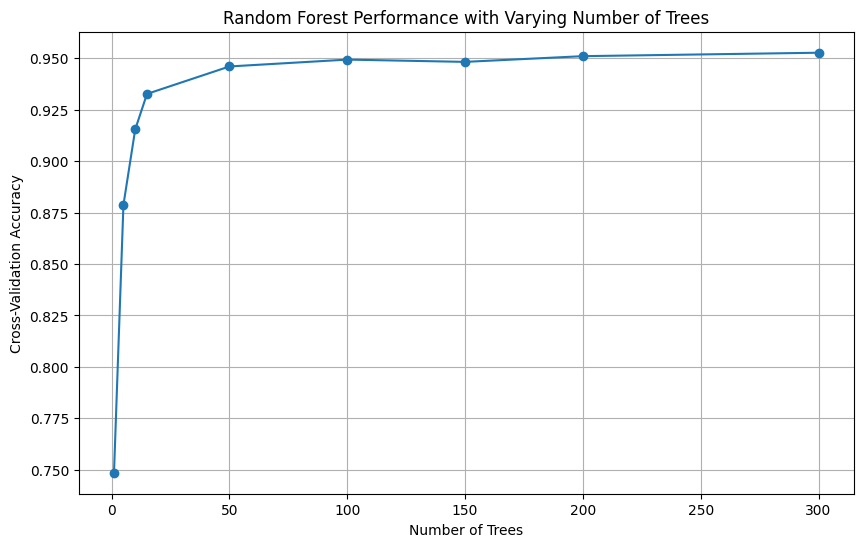

The best number of trees is: 300


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

n_estimators_list = [1, 5, 10, 15, 50, 100, 150, 200, 300]
cv_scores = []

for n_estimators in n_estimators_list:
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    scores = cross_val_score(rf_classifier, X, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, cv_scores, marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Random Forest Performance with Varying Number of Trees")
plt.grid(True)
plt.show()

best_n_estimators = n_estimators_list[cv_scores.index(max(cv_scores))]
print(f"The best number of trees is: {best_n_estimators}")

### 2.5 Количество признаков  (2 балла)

Переберите теперь максимальное количество признаков для `RandomForestClassifier` на 100 деревьях, от 1 до 64 с шагом 5. Постройте график качества по кроссвалидации на 10 фолдах.

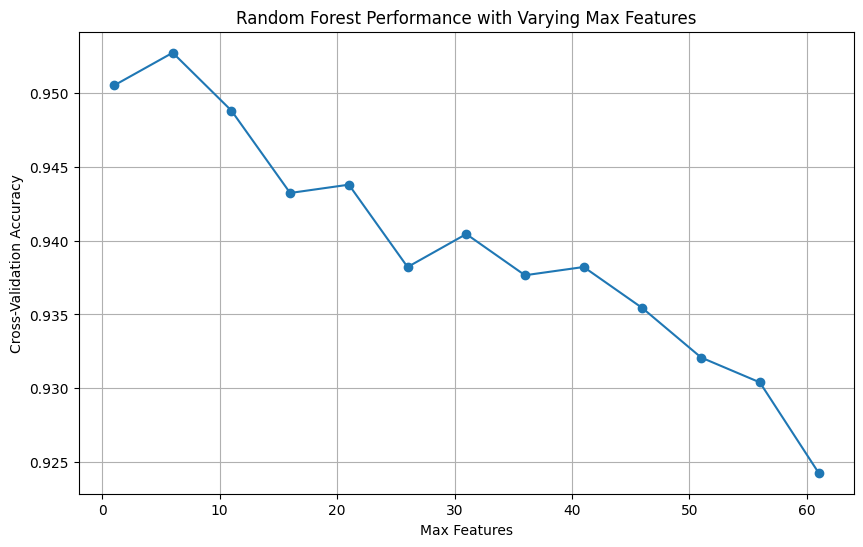

The best max features is: 6


In [23]:
max_features_list = range(1, 65, 5)
cv_scores_features = []

for max_features in max_features_list:
    rf_classifier = RandomForestClassifier(n_estimators=100, max_features=max_features, random_state=42)
    scores = cross_val_score(rf_classifier, X, y, cv=10, scoring='accuracy')
    cv_scores_features.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(max_features_list, cv_scores_features, marker='o')
plt.xlabel("Max Features")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Random Forest Performance with Varying Max Features")
plt.grid(True)
plt.show()

best_max_features = max_features_list[cv_scores_features.index(max(cv_scores_features))]
print(f"The best max features is: {best_max_features}")

### 2.5 Вопросы по RandomForest (8 баллов)

Ответьте на вопросы:

- Что происходит с ростом числа деревьев у случайного леса. Можно ли просто всегда брать 5000 деревьев и быть счастливым?
- Как зависит качество предсказания в дереве в зависимости от max_features?
- Почему качество зависит от max_features?
- Как глубина деревьев влияет на качество случайного леса?

Давайте разберем вопросы по случайному лесу.

**Что происходит с ростом числа деревьев у случайного леса? Можно ли просто всегда брать 5000 деревьев и быть счастливым?**

С ростом числа деревьев в случайном лесу, качество модели (на валидационной выборке) обычно улучшается, достигая плато.  Первые деревья вносят наибольший вклад, последующие – все меньше.  В какой-то момент добавление новых деревьев перестает значительно улучшать качество, а затраты на вычисления растут.  Поэтому, 5000 деревьев – это, скорее всего, избыточно.  Оптимальное число деревьев зависит от конкретного набора данных.  Лучше всего найти это значение экспериментально, например, используя кросс-валидацию, как показано в у нас коде, следя за метрикой качества на валидации, а не просто брать большое число деревьев, не проверяя результаь

**Как зависит качество предсказания в дереве в зависимости от `max_features`?**

Параметр `max_features` определяет количество случайных признаков, которые рассматриваются при каждом разбиении в узле дерева. При малых значениях `max_features` каждое дерево будет менее коррелировано с другими, что уменьшит переобучение.  Однако, при слишком малых значениях деревья могут быть слишком слабыми,  и качество модели снизится.  Оптимальное значение  `max_features` это баланс между разнообразием деревьев и их качеством. В нашем примере график показывает, что качество растет с увеличением количества признаков, достигая максимума, а затем снижается

**Почему качество зависит от `max_features`?**

Качество зависит от `max_features`, потому что данный параметр влияет на разнообразие деревьев в лесу. Если `max_features` мало, каждое дерево видит лишь небольшую часть признаков,  обучаясь на разных аспектах данных.  Это снижает корреляцию между деревьями и, следовательно, уменьшает переобучение.  При большом `max_features`, деревья становятся более похожими,  и  модель склонна к переобучению

**Как глубина деревьев влияет на качество случайного леса?**

Глубина деревьев – это еще один важный гиперпараметр.  Маленькая глубина приводит к слабым деревьям (т.е. они не могут уловить сложных зависимостей), а большая глубина – к переобучению.  Слишком глубокие деревья могут идеально подстраиваться под обучающие данные, но плохо предсказывать новые.  Обычно оптимальная глубина находится между этими двумя крайностями.  Как и в случае с количеством деревьев и количеством признаков, лучший способ ее определить — кросс-валидация


![](https://habrastorage.org/web/ad8/366/a44/ad8366a4469346c6b2e1306495b05d1a.jpg)